In [1]:
''' Let's apply the previous CNN model to a dataset of flowers.
        
    Data source: https://www.kaggle.com/alxmamaev/flowers-recognition
'''

import os, itertools
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

from skimage.transform import resize

from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split

from keras.callbacks import ReduceLROnPlateau, ModelCheckpoint
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from keras.models import Sequential
from keras.optimizers import RMSprop
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing.image import img_to_array, load_img
from keras.utils.np_utils import to_categorical

BASE_DIR = '../../datasets/learn_statistics/classification/flowers/'
MY_DATA_DIR = '../../mydatadir/learn_statistics/classification/flowers/'

im_w, im_h, im_c = 173, 173, 3

In [2]:
flower_names = ['daisy', 'sunflower', 'tulip', 'dandelion', 'rose']
n_classes = len(flower_names)

In [3]:
y = []
X_paths = []

k =  0
for flower_name in flower_names:
    
    flower_dir = os.path.join(BASE_DIR, flower_name)
    
    for img_name in os.listdir(flower_dir):
        X_paths.append(os.path.join(flower_dir, img_name))
        y.append(k)
        
    k += 1
    
y = np.array(y)
X_paths = np.array(X_paths)

In [4]:
X = np.empty(shape=(len(y), im_w, im_h, im_c), dtype=float)

for i, X_path in enumerate(X_paths):
    im = load_img(X_path)
    im = img_to_array(im)
    
    im = resize(im, (im_w, im_h, im_c), mode='constant', preserve_range=True)
    
    X[i] = im / 255.0

In [5]:
print('Memory usage, \n\
  X: {0:.1f} MB, y: {1:.3f} MB'.format(X.nbytes/1e6, y.nbytes/1e6)) 

Memory usage, 
  X: 3105.2 MB, y: 0.035 MB


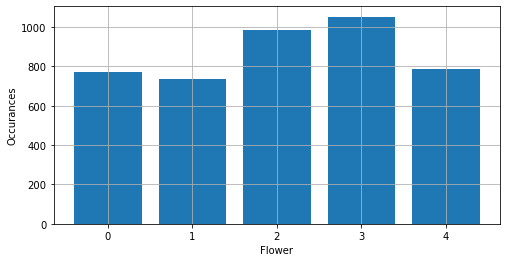

In [6]:
nums, counts = np.unique(y, return_counts=True)

fig, ax = plt.subplots(1, figsize=(8, 4)) 

ax.bar(nums, counts)
ax.set_title('')
ax.set_xlabel('Flower')
ax.set_ylabel('Occurances')

ax.grid() 

In [7]:
y_hot = to_categorical(y, num_classes=n_classes) 

X_train, X_valid, y_train, y_valid = train_test_split(
    X, y_hot, 
    test_size = 0.1, 
    random_state = 3) 

print(X_train.shape)
print(X_valid.shape)
print(y_train.shape)
print(y_valid.shape) 

(3890, 173, 173, 3)
(433, 173, 173, 3)
(3890, 5)
(433, 5)


In [8]:
def create_model():
    ''' CNN architechture 
            In -> [ (Conv2D -> relu) * 2
               ->    MaxPool2D 
               ->    Dropout ] * 2 
               -> Flatten 
               -> Dense
               -> Dropout 
               -> Dense
               -> Out  '''

    model = Sequential()

    model.add(Conv2D(filters=32, kernel_size=(5,5), padding='Same', activation='relu', 
                     input_shape=(im_w, im_h, im_c)))
    model.add(Conv2D(filters=32, kernel_size=(5,5), padding='Same', activation='relu'))
    model.add(MaxPool2D(pool_size=(2,2)))
    model.add(Dropout(0.25))

    model.add(Conv2D(filters=64, kernel_size=(3,3), padding='Same', activation='relu'))
    model.add(Conv2D(filters=64, kernel_size=(3,3), padding='Same', activation='relu'))
    model.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))
    model.add(Dropout(0.25))

    model.add(Flatten())
    model.add(Dense(256, activation = "relu"))
    model.add(Dropout(0.5))
    model.add(Dense(n_classes, activation = "softmax"))    
    
    optimizer = RMSprop()

    model.compile(optimizer = optimizer, 
                  loss = "categorical_crossentropy", 
                  metrics = ["accuracy"])
    
    return model


learning_rate_reduction = ReduceLROnPlateau(monitor = 'val_accuracy')

checkpoint = ModelCheckpoint('02_flowers.h5', save_best_only = True, 
                             save_weights_only = True)

datagen = ImageDataGenerator(
    featurewise_center = False,  
    samplewise_center = False,  
    featurewise_std_normalization = False,  
    samplewise_std_normalization = False,  
    
    zca_whitening = False,  
    
    # Augment
    rotation_range = 10,  
    zoom_range = 0.1, 
    width_shift_range = 0.1,  
    height_shift_range = 0.1
)

datagen.fit(X_train) 

In [9]:
epochs = 5
batch_size = 43

model = create_model()

history = model.fit(
    datagen.flow(X_train, y_train, batch_size=batch_size),
    epochs = epochs, 
    validation_data = (X_valid, y_valid),
    steps_per_epoch = X_train.shape[0] // batch_size, 
    callbacks = [learning_rate_reduction, checkpoint]
)

Epoch 1/5
90/90 [==============================] - 188s 2s/step - loss: 2.7068 - accuracy: 0.2488 - val_loss: 1.5861 - val_accuracy: 0.3233 - lr: 0.0010
Epoch 2/5
90/90 [==============================] - 187s 2s/step - loss: 1.5391 - accuracy: 0.3462 - val_loss: 1.3694 - val_accuracy: 0.4065 - lr: 0.0010
Epoch 3/5
90/90 [==============================] - 187s 2s/step - loss: 1.3495 - accuracy: 0.4494 - val_loss: 1.1223 - val_accuracy: 0.5727 - lr: 0.0010
Epoch 4/5
90/90 [==============================] - 190s 2s/step - loss: 1.1755 - accuracy: 0.5282 - val_loss: 1.1010 - val_accuracy: 0.5658 - lr: 0.0010
Epoch 5/5
90/90 [==============================] - 186s 2s/step - loss: 1.1458 - accuracy: 0.5433 - val_loss: 1.0984 - val_accuracy: 0.5473 - lr: 0.0010


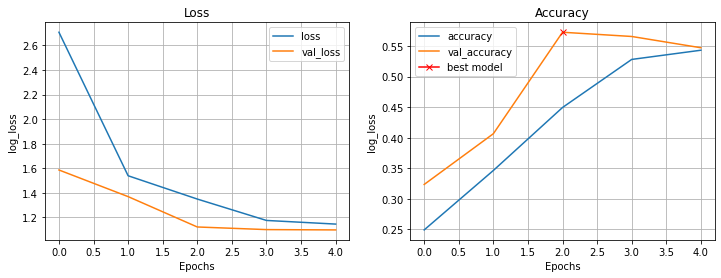

In [10]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

# Loss
ax1.plot(history.history['loss'], label='loss')
ax1.plot(history.history['val_loss'], label='val_loss')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('log_loss')
ax1.set_title('Loss')
ax1.legend()
ax1.grid()

# Accuracy
ax2.plot(history.history['accuracy'], label='accuracy')
ax2.plot(history.history['val_accuracy'], label='val_accuracy')
ax2.plot(np.argmax(history.history["val_accuracy"]), 
         np.max(history.history["val_accuracy"]), 
                marker='x', color='r', label='best model')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('log_loss')
ax2.set_title('Accuracy')
ax2.legend()
ax2.grid()

plt.show() 

In [11]:
# Load the best model
model.load_weights('02_flowers.h5') 

model.evaluate(X_valid, y_valid, verbose=1) 

14/14 [==============================] - 4s 314ms/step - loss: 1.0984 - accuracy: 0.5473


[1.0983830690383911, 0.5473440885543823]

In [12]:
y_pred_prob = model.predict(X_valid)
y_pred = np.argmax(y_pred_prob, axis=1) 
y_true = np.argmax(y_valid, axis=1)

Cm = np.array(confusion_matrix(y_true, y_pred)) 

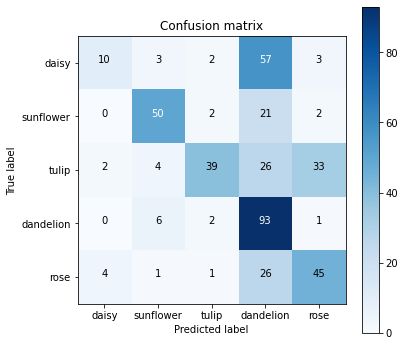

In [13]:
fig, ax = plt.subplots(1, figsize=(6, 6))

im = ax.imshow(Cm, interpolation='nearest', cmap=plt.cm.Blues)
fig.colorbar(im)

ax.set_title('Confusion matrix')
ax.set_ylabel('True label')
ax.set_xlabel('Predicted label')

thresh = Cm.max() / 2.
for i, j in itertools.product(range(Cm.shape[0]), 
                              range(Cm.shape[1])):
    ax.text(j, i, Cm[i, j],
             horizontalalignment = "center",
             color= "white" if Cm[i, j] > thresh else "black")

ticks = list(range(n_classes))
tick_labels = flower_names
    
ax.set_xticks(ticks)
ax.set_xticklabels(tick_labels, rotation=0)
ax.set_yticks(ticks)
ax.set_yticklabels(tick_labels)

plt.show() 

In [14]:
idx_err = np.argwhere((y_pred - y_true != 0)).flatten()

# Probabilities of the mistaken predictions
y_pred_prob_errors = np.max(y_pred_prob[idx_err], axis=1)
# Probabilities of the true values, where mistaken
true_prob_errors = np.empty(shape=len(idx_err), dtype=float)
for i, idx in enumerate(idx_err):
    true = y_true[idx]
    probabilites = y_pred_prob[idx].flatten()
    true_prob_errors[i] = probabilites[true]

# Define the most significant errors
delta_err = y_pred_prob_errors - true_prob_errors
idx = np.argsort(delta_err)
idx_errors_sorted = idx_err[idx[::-1]] 

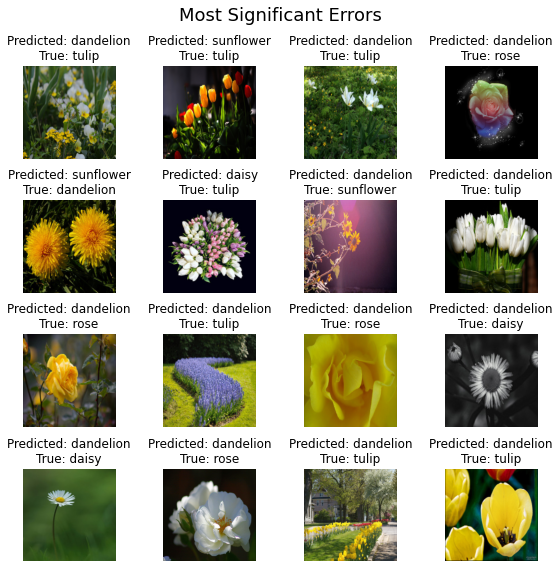

In [15]:
fig, axes = plt.subplots(4, 4, figsize=(8, 8))

n = 0
nrows = 4
ncols = 4

for i, ax in enumerate(axes.flatten()):
    
    idx = idx_errors_sorted[i]
    ax.imshow(X_valid[idx])
    
    p = flower_names[y_pred[idx]]
    t = flower_names[y_true[idx]]
    
    s = "Predicted: {0:s}\nTrue: {1:s}".format(p, t)
    ax.set_title(s)
    ax.axis('off')
    
fig.suptitle('Most Significant Errors', fontsize=18)
fig.tight_layout() 